# RL_Crossentropy 

In [13]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

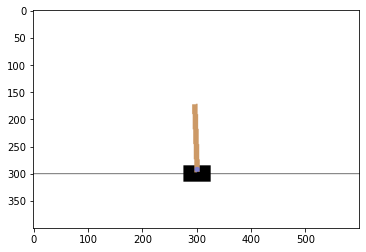

In [14]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [15]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
   
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = [states_batch[i] for i in range(len(rewards_batch)) if rewards_batch[i]>=reward_threshold]
    elite_states = [item for sublist in elite_states for item in sublist]
    
    elite_actions = [actions_batch[i] for i in range(len(rewards_batch)) if rewards_batch[i]>=reward_threshold]
    elite_actions = [item for sublist in elite_actions for item in sublist]
    
    return elite_states, elite_actions

In [16]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [17]:
# create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(
    hidden_layer_sizes=(20,10,10),
    activation='tanh',
    warm_start=True,  # keep progress between .fit(...) calls
    max_iter=1,  # make only 1 iteration on each .fit(...)
)
# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions))

C:\D\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 10, 10), max_iter=1,
              warm_start=True)

In [18]:
def generate_session(t_max=15000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent.predict_proba([s])[0]
        
        #sample action with such probabilities 
        a = np.random.choice(n_actions, p = probs)
        
        new_s, r, done, info = env.step(a)
        
        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

mean reward = 3863.649, threshold=8942.991


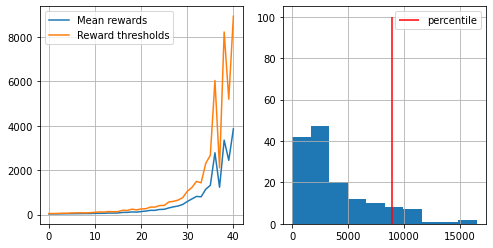

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [19]:
n_sessions = 150
percentile = 90
log = []

for i in range(10000):
    # generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [20]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="video_2", force=True)
sessions = [generate_session(t_max=10000) for _ in range(1)]
env.close()